In [7]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
from numpy import linalg as LA

# Data Preprocessing

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6

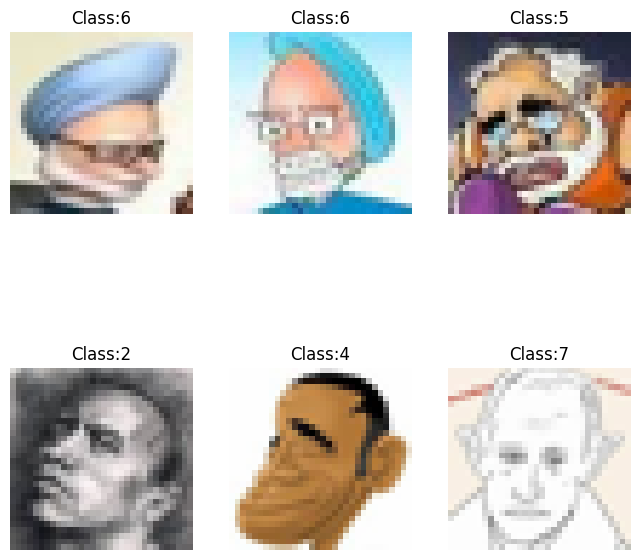

In [8]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list


dirpath = 'PCA_DATA/IIIT-CFW/IIIT-CFW'
X,y = load_data(dirpath)
Z = X.reshape(X.shape[0], -1)
print(y)
print(Z.shape)
# print(Z[0][31])
# [[[a,b,c]....32 times]...32 times]
N,H,W = X.shape[0:3]
# print(N,H,W)
C = 1 if opt['is_grayscale'] else X.shape[3]
ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

Implementation of Principle Component Analysis

[[ 5.60506621e-01  3.95854565e-01  7.03242475e-02 ... -2.08945026e-01
   7.00090776e-02 -1.69716136e-01]
 [ 3.95854565e-01  6.83268671e-01  6.26095192e-02 ... -1.74137216e-01
  -1.61730979e-02 -1.62892536e-01]
 [ 7.03242475e-02  6.26095192e-02  4.15624567e-01 ... -2.98338864e-02
   5.09123453e-02 -6.25758019e-03]
 ...
 [-2.08945026e-01 -1.74137216e-01 -2.98338864e-02 ...  2.65621427e-01
  -3.70471985e-04  1.36364792e-01]
 [ 7.00090776e-02 -1.61730979e-02  5.09123453e-02 ... -3.70471985e-04
   3.84286380e-01  8.08446523e-03]
 [-1.69716136e-01 -1.62892536e-01 -6.25758019e-03 ...  1.36364792e-01
   8.08446523e-03  2.09457597e-01]]
(672, 672)
672
[ 8.05321772e+01  1.99819287e+01  1.29505097e+01  7.10403262e+00
  6.46406331e+00  5.79378157e+00  4.39351523e+00  4.29762441e+00
  3.90835565e+00  3.06725550e+00  2.59805032e+00  2.45102161e+00
  2.23299791e+00  2.09318300e+00  1.99404458e+00  1.87642462e+00
  1.84819775e+00  1.75147583e+00  1.54625082e+00  1.47619947e+00
  1.37650633e+00  1.3650

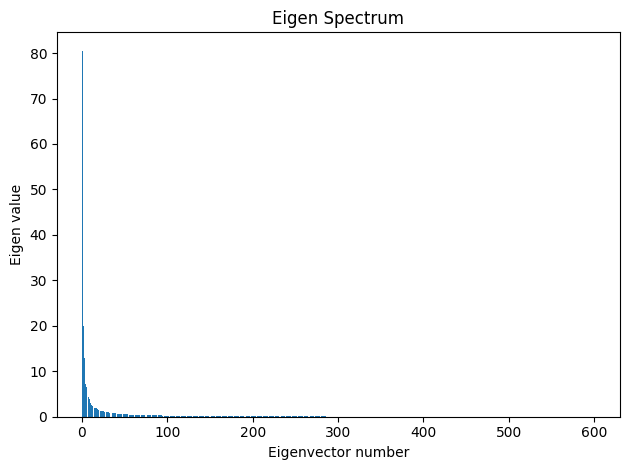

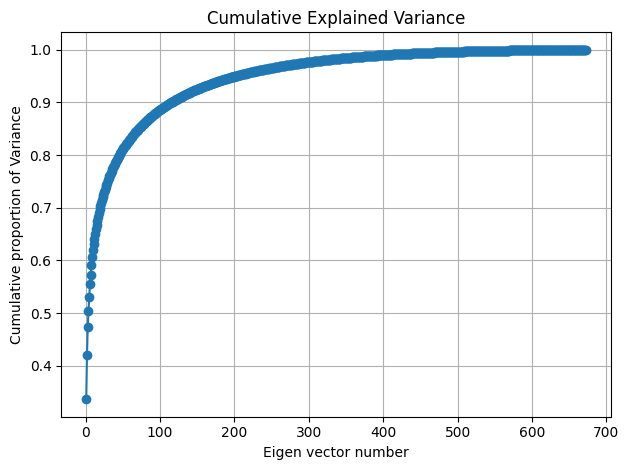

In [27]:
# class sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

# Assume that we start with a data set that is represented in terms of an m × n matrix, X ; where the n columns are the samples (e.g. observations) and the m rows are the variables
class PCA:
    def __init__(self,n_components_=None,components_ = None,mean_=None,explained_variance_ratio_=None):
        self.n_components_ = n_components_ # The estimated number of components
        self.components_ = components_ # ndarray of shape (n_components, n_features)
        self.mean_ = mean_ # ndarray of shape (n_features,) Per-feature empirical mean, estimated from the training set.
        self.explained_variance_ratio_ = explained_variance_ratio_
    def fit(self,X):
        num_samples = X.shape[0]
        Z = X.reshape(num_samples,-1)
        Z = np.array(Z)
        mean = np.mean(Z,axis=0) # calculates mean along columns in a single row
        self.mean_ = mean
        # Suppose we have a vector of n discrete measurements, r̃ = (r̃1 ,r̃2 , . . . , r̃n), with mean µr .If we subtract the mean from each of the measurements, then we obtain a translated set of measurements r = (r1 ,r2 , . . . , rn), that has zero mean.
        R = (Z - mean.reshape(1,-1))
        # Covariance can be thought of as a measure of how much two variables change together. Variance is thus a special case of covariance, when the the two variables are identical.
        C = (R@R.T)/(num_samples-1)
        # print(C)
        # print(C.shape)
        print(num_samples)
        eigenvalues, eigenvectors = LA.eigh(C) # Return the eigenvalues and eigenvectors of a complex Hermitian (conjugate symmetric) or a real symmetric matrix , matrix deals with XX^T
        sorted_indices = np.argsort(-eigenvalues)
        self.eigen_values = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        self.eigen_vectors = eigenvectors
        total_variance = np.sum(self.eigen_values)
        self.explained_variance_ratio_ = np.cumsum(self.eigen_values/total_variance)
    def transform(self,X):
        if n_components is None:
            n_components = self.components.shape[1]
        num_samples = X.shape[0]
        Z = X.reshape(num_samples,-1)
        Z = np.array(Z)
    def eigen_spectrum(self,num_components = None):
        print(self.eigen_values)
        if num_components is None:
            num_components = self.n_components_
        top_eigen_values = self.eigen_values[:600]
        plt.bar(range(1,601),top_eigen_values)
        plt.xlabel('Eigenvector number')
        plt.ylabel('Eigen value')
        plt.title('Eigen Spectrum')
        plt.tight_layout()
        plt.show()
    def plot_cumulative_variance(self):
        plt.plot(np.arange(1, len(self.explained_variance_ratio_) + 1), self.explained_variance_ratio_, marker='o')
        plt.xlabel('Eigen vector number')
        plt.ylabel('Cumulative proportion of Variance')
        plt.title('Cumulative Explained Variance')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

n_components = 20
pca = PCA(20)
pca.fit(X)
pca.eigen_spectrum()
pca.plot_cumulative_variance()



        

